# COSC2673 - Machine Learning
# Assignment 2
## Group Name - The Puzzle's
### Student Name - Akash Hirani (s3758654)
###                            Pranav Malaviya(s3752685)


### Reading data

In [1]:
import zipfile
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


#### Check for null values.

In [3]:
data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

There are no null values found in the given dataset.
#### Let's look at the distribution of isCancerous

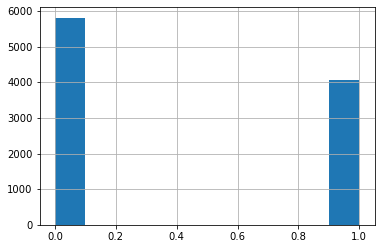

In [5]:
data.isCancerous.hist()
plt.show()

The dataset is fairly unbiased as there is not much difference between number of samples belonging to both the classes.

#### A stacked bar chart to understand the relationship between the two target variables.

<AxesSubplot:xlabel='isCancerous'>

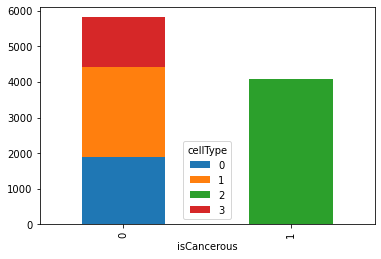

In [6]:
temp = data.groupby(['isCancerous','cellType'])['isCancerous'].count().unstack('cellType')
temp.plot(kind = 'bar',stacked = True)

The above graph manifests that all the cells that are cancerous are of type 2 in this dataset.
Let's have a look at the cell type names associated with the cellType labels.

In [7]:
set(list(zip(data["cellType"],data["cellTypeName"])))

{(0, 'fibroblast'), (1, 'inflammatory'), (2, 'epithelial'), (3, 'others')}

#### Split the dataset into train, validation and test datasets.

In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


#### Define a function to plot train and validations loss and categorical accuracy for a given model. 

In [9]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

#### Declare initial parameters.
Since the size of the images given for processing is 27x27 we dclare input dimensions as (27,27,3) and there are 2 classes of the target variable cellType hene we define output_classes as 2

In [10]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [11]:
#! pip install tensorflow
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.4.1'

### Determination of goals
Based on our reference to the original research from where the dataset has been derived, Metrics such as precision, recall and f1 score (weighted f1 score) were for performance evaluation of models where the highest weighted f1-score achieved in classification of isCancerous was found to be 0.99. Based on these values and the fact that the original dataset was 500x500 pixels but the one we are using is only 27x27 pixels we set our target f1 to be 0.90.

#### First we tried basic sequential keras model to get a better understanding of neural networks.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


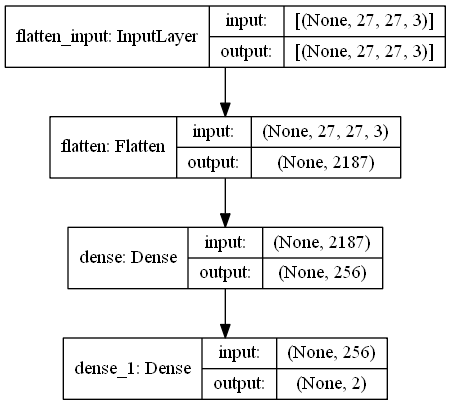

In [14]:
#! pip install pydot
#! pip install graphviz
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [16]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

#### Since the image size is small we use keras ImageDataGenerator as a common regularisation technique for all our models to rescale the images as this data augmentation would help our models train better.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [18]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


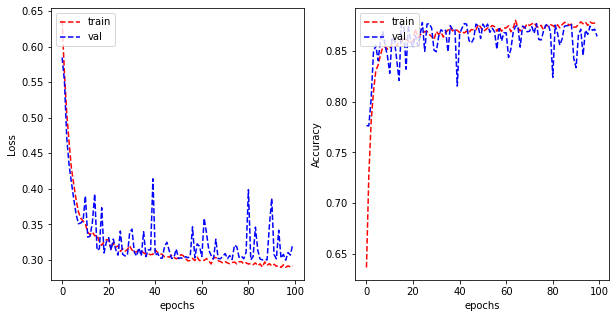

In [19]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

#### rescale test data as well and resize it to the same size as that of train and validation data if needed and use a batch size of 1 so as to test 1 image at a time. 

In [20]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


<ipython-input-20-069a0c34f0ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['isCancerous'] = test_data['isCancerous'].astype('str')


In [21]:
model.evaluate(test_generator)

1980/1980 [==============================] - 11s 6ms/step - loss: 0.3247 - categorical_accuracy: 0.8606


[0.32466593384742737, 0.8606060743331909]

In [22]:
label_names = {'no' : 0, 'yes' : 1}

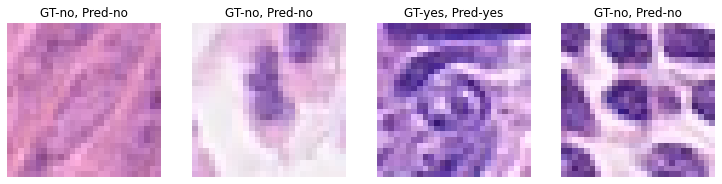

In [23]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

### Default Baseline Model
After taking GoogleNet, ResNet and VGG in consideration as our baseline model, we found out that GoogleNet and ResNet have architectures that are way more complex than VGG. Even though VGG is more expensive computationally, we realise that since we have smaller image sizes it would not affect our task significantly as we will need only fewer layers in VGG compared to it's original architechture that was designed for higher resolution (224x224) images.

On further detailed study of the structure of the VGG, we notice that it consists of many blocks (A block consists of: convolution + activation + pooling). Those blocks will lead to downscaling of the image due to the use of the max pooling layer. In the original VGG, there are many such blocks because the input image size is 224x224. What we can do is use only a few VGG blocks to construct the network. 

First we create a VGG with 3 blocks
We use sigmoid as activation function in the final layer as it was used by the owner of the dataset in their research article and also, sigmoid is effcient for us as this is a binary classification problem and we need the model to be able to give probability of each class while making predictions to be able to implement semi-supervised learning in forth-coming stages.

In [29]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation = 'sigmoid'),
])

- VGG has 3x3 convolution kernels only.
- Pooling is always max-pooling and they are (2x2).
- Padding is same - No boarder pixels lost when applying convolutions. 
- activation is softmax

Lets compile the model and fit.

In [30]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

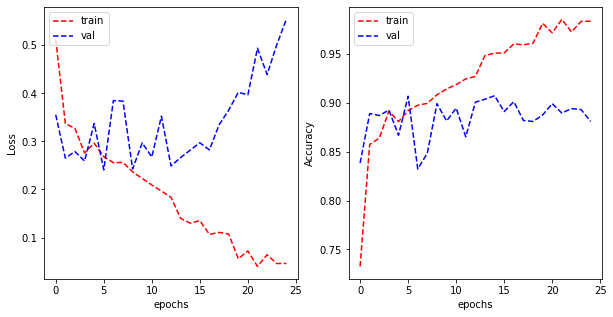

In [32]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['accuracy'], history_VGG_1.history['val_accuracy'], 
                    metric_name='Accuracy')

In [33]:
model_VGG_1.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.6122 - accuracy: 0.8798


[0.6122272610664368, 0.8797979950904846]

Since the above model is overfitting we try using l2 regularisation and dropout in the next incremental model.

In [34]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [35]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

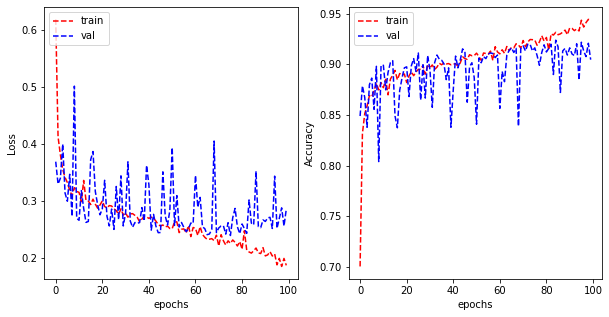

In [36]:
history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['accuracy'], history_VGG_2.history['val_accuracy'], 
                    metric_name='Accuracy')

In [37]:
model_VGG_2.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.3203 - accuracy: 0.9045


[0.3202548325061798, 0.9045454263687134]

The above model has an accuracy of 0.90 which is our target accuracy.
To look if we could improve the accuracy any further let's try data augmentation in our next model. We perform data augmentation using rotation of image upto 15 degrees at a time, width and height shifts and brightness variations to the model. Note that we are performing these augmentations only on training data and not on validation or test data. Let's retrain and fit the model with augmented data. Also, this model does not use dropout.

In [38]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [39]:

reg_lambda = 0.001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation = 'sigmoid'),
])

In [40]:
model_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


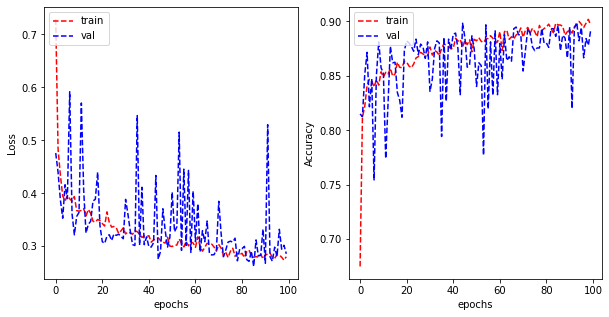

In [41]:
history_VGG_3 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['accuracy'], history_VGG_3.history['val_accuracy'], 
                    metric_name='Accuracy')

In [42]:
model_VGG_3.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.2975 - accuracy: 0.8929


[0.297488808631897, 0.8929293155670166]

The model does not seem to change much in the accuracy compared to the previous model, however the model has increased loss function compared to that of the previous model.
Let's have a look at the confusion matrices and classification reports of the two models.

In [71]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model_VGG_2.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Found 1980 validated image filenames belonging to 2 classes.
Accuracy score:  0.9045454545454545
F1 score:  0.9011493481673589
[[1079  110]
 [  79  712]]


In [72]:
print(classification_report(y_all,y_hat_all))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1189
           1       0.87      0.90      0.88       791

    accuracy                           0.90      1980
   macro avg       0.90      0.90      0.90      1980
weighted avg       0.91      0.90      0.90      1980



In [75]:
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))
print(classification_report(y_all,y_hat_all))

Accuracy score:  0.8929292929292929
F1 score:  0.8900576217915139
[[1044  145]
 [  67  724]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1189
           1       0.83      0.92      0.87       791

    accuracy                           0.89      1980
   macro avg       0.89      0.90      0.89      1980
weighted avg       0.90      0.89      0.89      1980



#### From the above classification reports we can see that model_VGG_2 performs only slightly better than the model_VGG_3. In our case here we can say that since we are determining if a cell is cancerous or not we would want our model to give higher True positives and lesser false negatives. Hence we choose model_VGG_2 as our final model. 

In [74]:
model_VGG_2.save("isCancerousFinalModel")

INFO:tensorflow:Assets written to: isCancerousFinalModel\assets
